This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Routine verification measures for radar-based precipitation estimates

In [1]:
import wradlib as wrl
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

## Extract bin values from a polar radar data set at rain gage locations

#### Read polar data set

In [2]:
filename = wrl.util.get_wradlib_data_file("misc/polar_R_tur.gz")
data = np.loadtxt(filename)

#### Define site coordinates (lon/lat) and polar coordinate system

In [3]:
r = np.arange(1, 129)
az = np.linspace(0, 360, 361)[0:-1]
site = (9.7839, 48.5861, 0)

#### Make up two rain gauge locations (say we want to work in Gaus Krueger zone 3)

In [4]:
# Define the projection via epsg-code
crs = wrl.georef.epsg_to_osr(31467)
# Coordinates of the rain gages in Gauss-Krueger 3 coordinates
x, y = np.array([3557880, 3557890]), np.array([5383379, 5383375])

#### Now extract the radar values at those bins that are closest to our rain gauges

For this purppose, we use the PolarNeighbours class from wraldib's verify module. Here, we extract the 9 nearest bins...

In [5]:
polarneighbs = wrl.verify.PolarNeighbours(r, az, site, crs, x, y, nnear=9)
radar_at_gages = polarneighbs.extract(data)
print("Radar values at rain gauge #1: %r" % radar_at_gages[0].tolist())
print("Radar values at rain gauge #2: %r" % radar_at_gages[1].tolist())

Radar values at rain gauge #1: [0.01, 0.02, 0.01, 0.01, 0.02, 0.05, 0.01, 0.01, 0.01]
Radar values at rain gauge #2: [0.2, 0.06, 0.15, 0.69, 0.06, 0.26, 0.05, 0.99, 0.32]


#### Retrieve the bin coordinates (all of them or those at the rain gauges)

In [6]:
binx, biny = polarneighbs.get_bincoords()
binx_nn, biny_nn = polarneighbs.get_bincoords_at_points()

#### Plot the entire radar domain and zoom into the surrounding of the rain gauge locations

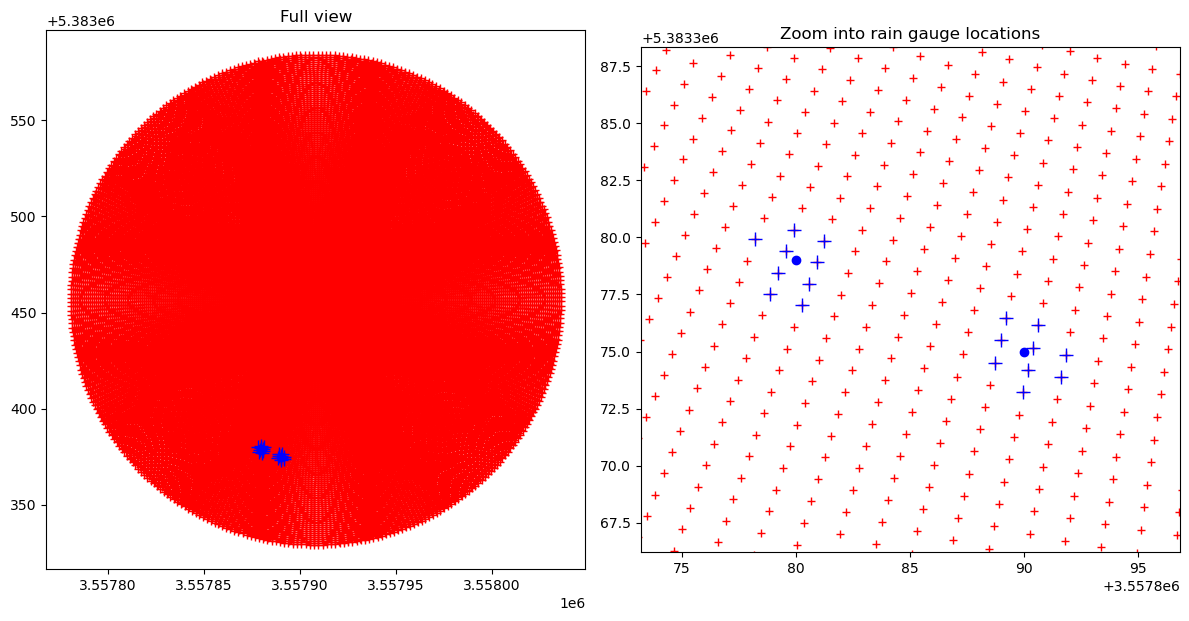

In [7]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(121)
ax.plot(binx, biny, "r+")
ax.plot(binx_nn, biny_nn, "b+", markersize=10)
ax.plot(x, y, "bo")
ax.axis("tight")
ax.set_aspect("equal")
plt.title("Full view")
ax = fig.add_subplot(122)
ax.plot(binx, biny, "r+")
ax.plot(binx_nn, biny_nn, "b+", markersize=10)
ax.plot(x, y, "bo")
plt.xlim(binx_nn.min() - 5, binx_nn.max() + 5)
plt.ylim(biny_nn.min() - 7, biny_nn.max() + 8)
ax.set_aspect("equal")
txt = plt.title("Zoom into rain gauge locations")
plt.tight_layout()

## Create a verification report

In this example, we make up a true Kdp profile and verify our reconstructed Kdp.

#### Create synthetic data and reconstruct KDP

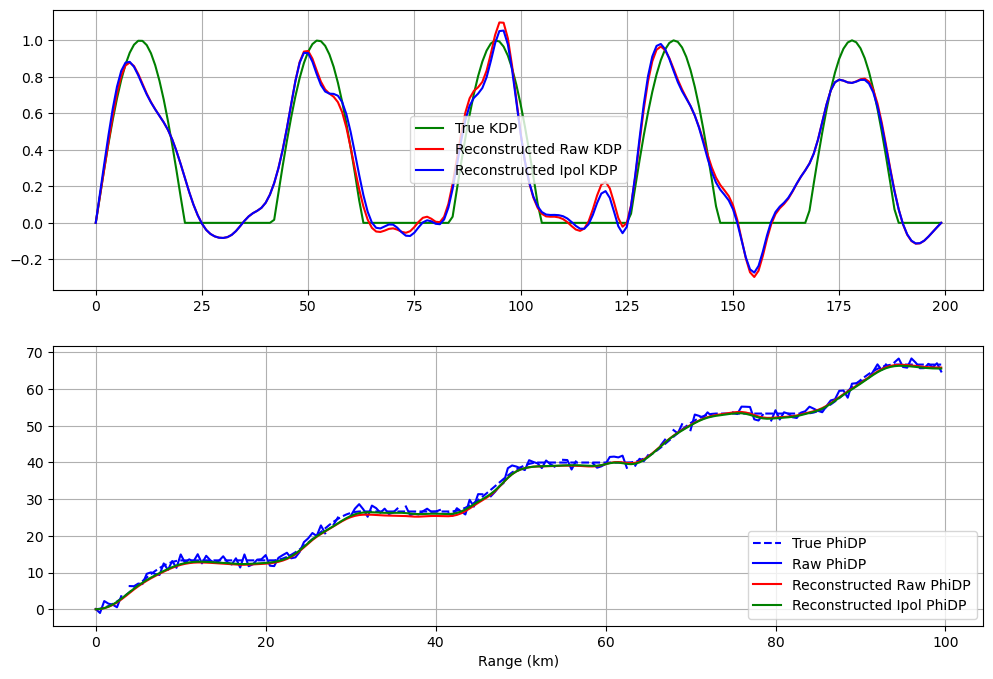

In [8]:
# Synthetic truth
dr = 0.5
r = np.arange(0, 100, dr)
kdp_true = np.sin(0.3 * r)
kdp_true[kdp_true < 0] = 0.0
phidp_true = np.cumsum(kdp_true) * 2 * dr
# Synthetic observation of PhiDP with a random noise and gaps
np.random.seed(1319622840)
phidp_raw = phidp_true + np.random.uniform(-2, 2, len(phidp_true))
gaps = np.random.uniform(0, len(r), 20).astype("int")
phidp_raw[gaps] = np.nan

# linearly interpolate nan
nans = np.isnan(phidp_raw)
phidp_ipol = phidp_raw.copy()
phidp_ipol[nans] = np.interp(r[nans], r[~nans], phidp_raw[~nans])

# Reconstruct PhiDP and KDP
phidp_rawre, kdp_rawre = wrl.dp.process_raw_phidp_vulpiani(phidp_raw, dr=dr)
phidp_ipre, kdp_ipre = wrl.dp.process_raw_phidp_vulpiani(phidp_ipol, dr=dr)

# Plot results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(211)
plt.plot(kdp_true, "g-", label="True KDP")
plt.plot(kdp_rawre, "r-", label="Reconstructed Raw KDP")
plt.plot(kdp_ipre, "b-", label="Reconstructed Ipol KDP")
plt.grid()
lg = plt.legend()

ax = fig.add_subplot(212)
plt.plot(r, phidp_true, "b--", label="True PhiDP")
plt.plot(r, np.ma.masked_invalid(phidp_raw), "b-", label="Raw PhiDP")
plt.plot(r, phidp_rawre, "r-", label="Reconstructed Raw PhiDP")
plt.plot(r, phidp_ipre, "g-", label="Reconstructed Ipol PhiDP")
plt.grid()
lg = plt.legend(loc="lower right")
txt = plt.xlabel("Range (km)")

#### Create verification report

{'corr': 0.95,
 'mas': 0.1,
 'meanerr': -0.0,
 'mse': 0.01,
 'nash': 0.93,
 'pbias': -0.0,
 'r2': 0.9,
 'ratio': nan,
 'rmse': 0.1,
 'spearman': 0.92,
 'sse': 2.96}
{'corr': 0.95,
 'mas': 0.1,
 'meanerr': -0.01,
 'mse': 0.01,
 'nash': 0.93,
 'pbias': -3.0,
 'r2': 0.91,
 'ratio': nan,
 'rmse': 0.1,
 'spearman': 0.92,
 'sse': 2.91}


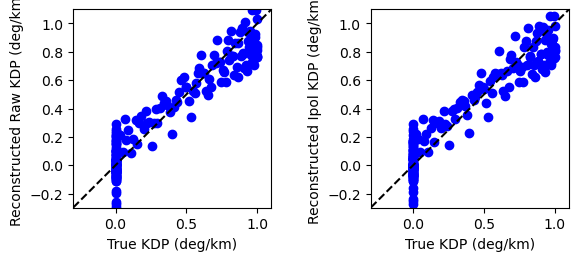

In [9]:
metrics_raw = wrl.verify.ErrorMetrics(kdp_true, kdp_rawre)
metrics_raw.pprint()
metrics_ip = wrl.verify.ErrorMetrics(kdp_true, kdp_ipre)
metrics_ip.pprint()

plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(121, aspect=1.0)
ax.plot(metrics_raw.obs, metrics_raw.est, "bo")
ax.plot([-1, 2], [-1, 2], "k--")
plt.xlim(-0.3, 1.1)
plt.ylim(-0.3, 1.1)
xlabel = ax.set_xlabel("True KDP (deg/km)")
ylabel = ax.set_ylabel("Reconstructed Raw KDP (deg/km)")
ax = plt.subplot(122, aspect=1.0)
ax.plot(metrics_ip.obs, metrics_ip.est, "bo")
ax.plot([-1, 2], [-1, 2], "k--")
plt.xlim(-0.3, 1.1)
plt.ylim(-0.3, 1.1)
xlabel = ax.set_xlabel("True KDP (deg/km)")
ylabel = ax.set_ylabel("Reconstructed Ipol KDP (deg/km)")